In [1]:
import sys 
sys.path.append('../scripts/')
from dp_policy_agent import *

In [2]:
class StateInfo: ###q4stateinfo
    def __init__(self, action_num, epsilon=0.3):
        self.q = np.zeros(action_num)
        self.epsilon = epsilon
        
    def greedy(self):
        return np.argmax(self.q)
    
    def epsilon_greedy(self, epsilon): 
        if random.random() < epsilon:
            return random.choice(range(len(self.q)))
        else:
            return self.greedy()
    
    def pi(self):
        return self.epsilon_greedy(self.epsilon) 
    
    def max_q(self):              #追加
        return max(self.q)

In [3]:
class QAgent(DpPolicyAgent): ###q4qagent
    def __init__(self, time_interval, estimator, puddle_coef=100,  alpha=0.5, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8]): #alpha追加
        super().__init__(time_interval, estimator, None, puddle_coef, widths, lowerleft, upperright)
        
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        self.actions = list(set([tuple(self.policy_data[i]) for i in self.indexes]))
        self.ss = self.set_action_value_function()
        
        ###強化学習用変数### #追加
        self.alpha = alpha
        self.s, self.a = None, None
        self.update_end = False

    def set_action_value_function(self): #状態価値関数を読み込んで行動価値関数を初期化
        ss = {} #state spaceという意味
        for line in open("puddle_ignore_values.txt", "r"): #価値のファイルを読み込む
            d = line.split()
            index, value = (int(d[0]), int(d[1]), int(d[2])), float(d[3]) #インデックスをタプル、値を数字に
            ss[index] = StateInfo(len(self.actions)) #StateInfoオブジェクトを割り当てて初期化
            
            for i, a in enumerate(self.actions): #方策の行動価値を価値のファイルに書いてある値に。そうでない場合はちょっと引く
                ss[index].q[i] = value if tuple(self.policy_data[index]) == a else value - 0.1
                
        return ss
    
    def policy(self, pose, goal=None): #q4policy
        index = self.to_index(pose, self.pose_min, self.index_nums, self.widths)               
        s = tuple(index)
        a = self.ss[s].pi()
        return s, a                 #状態をタプルにしたものと、行動のインデックスで返すように変更
    
    def decision(self, observation=None):###q4decision
        ###終了処理###
        if self.update_end:  return 0.0, 0.0
        if self.in_goal:          self.update_end = True #ゴールに入った後も一回だけ更新があるので即終了はしない
        
        ###カルマンフィルタの実行###
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.estimator.observation_update(observation)
        
        ###行動決定と報酬の処理###
        s_, a_ = self.policy(self.estimator.pose) #KFの結果から前回の状態遷移後の状態s'と次の行動a_（max_a'のa'ではないことに注意）を得る
        r = self.time_interval*self.reward_per_sec() #状態遷移の報酬
        self.total_reward += r
        
        ###Q学習と現在の状態と行動の保存###
        self.q_update(self.s, self.a, r, s_)      #self.s, self.aがQ値更新対象の状態行動対。報酬rと次の状態s_を使って更新。
        self.s, self.a = s_, a_

        ###出力###
        self.prev_nu, self.prev_omega = self.actions[a_]
        return self.actions[a_]
    
    def q_update(self, s, a, r, s_):###q4update
        if s == None:  return
        
        q = self.ss[s].q[a]
        q_ = self.final_value if self.in_goal else self.ss[s_].max_q()
        self.ss[s].q[a] = (1.0 - self.alpha)*q + self.alpha*(r + q_)

        ###ログをとる（あとから削除）###
        with open("log.txt", "a") as f:
            f.write("{} {} {} prev_q:{:.2f}, next_step_max_q:{:.2f}, new_q:{:.2f}\n".format(s, r, s_, q, q_, self.ss[s].q[a]))

<IPython.core.display.Javascript object>


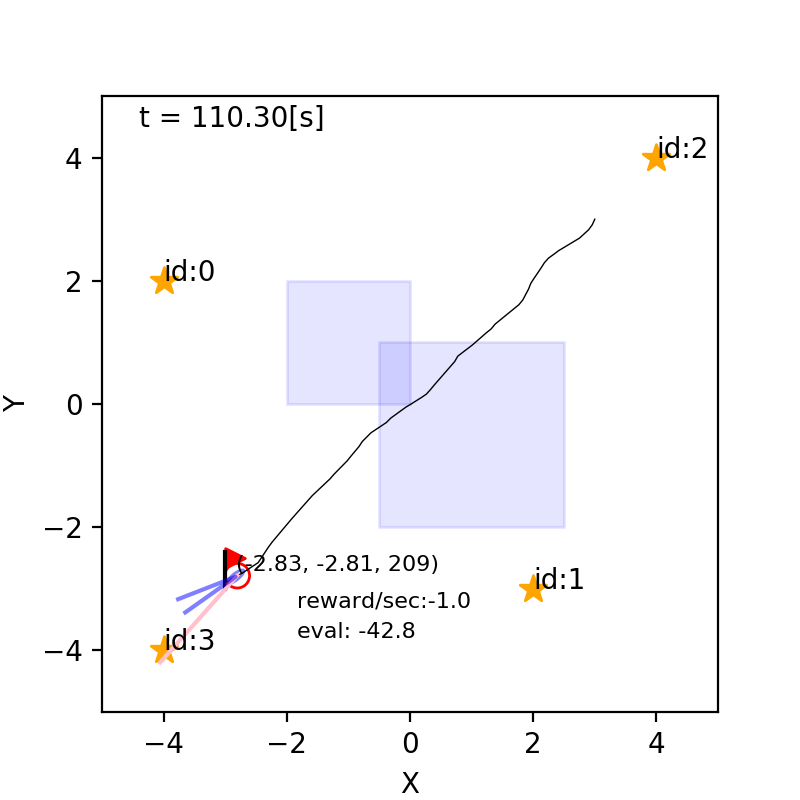

In [4]:
def trial(): 
    time_interval = 0.1
    world = PuddleWorld(400000, time_interval, debug=False)  #長時間アニメーション時間をとる

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (4,4), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3) 
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

    ##ロボットを1台登場させる##
    init_pose = np.array([3, 3, 0]).T
    kf = KalmanFilter(m, init_pose)
    a = QAgent(time_interval, kf) #goalを削除
    r = Robot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))
    world.append(r)
    
    world.draw()
    return a
    
a = trial()